# CX 4230, Spring 2016: [36] Dynamical systems on networks

This lab accompanies the slides from the last class: https://t-square.gatech.edu/access/content/group/gtc-59b8-dc03-5a67-a5f4-88b8e4d5b69a/cx4230-sp16--34--dyn-sys-nets.pdf

## A conceptual model of "opinion dynamics"

To illustrate the interesting dynamics possible on a network, we'll look at an example considered by [Pluchino et al. (2005)](http://arxiv.org/abs/cond-mat/0410217v2). They were interested in the following question about a network of interacting agents:

> Can agents with different intitial states converge to one or a few uniform states?

They were especially interested in a social network of people where the "states" are differing opinions: if everyone has a different opinion initally, can they still reach agreement? They were inspired by biological systems, like [synchronizing fireflies](https://www.youtube.com/watch?v=a-Vy7NZTGos). For more fun background on this topic, see this TED talk by Steven Strogatz: https://www.youtube.com/watch?v=aSNrKS-sCE0

In Pluchino et al.'s mathematical model, they considered $x_i \equiv x_i(t) \in \mathcal{R}$ to be some measure of the "opinion" of person $i$. It can be positive or negative, and it can take any value in $(\infty, \infty)$. These people are connected in a social network, represented as an undirected graph given by its adjacency matrix, $A \equiv (a_{ij})$, where $a_{ij} = 1$ if persons $i$ and $j$ are connected, and 0 otherwise.

They hypothesized a model of the dynamics of $x_i(t)$ by the system of ODEs,

$$\dfrac{dx_i}{dt} \equiv f_i(\vec{x}) \equiv w_i + \dfrac{K}{d_i} \sum_j a_{ij} \cdot \sin \theta_{ij} \cdot \exp \left( -\alpha \cdot \theta_{ij}^2 \right),$$

where $K$ and $\alpha$ are model parameters, $d_i$ is the degree (number of neighbors) of $i$, and $\theta_{ij} \equiv x_j - x_i$, that is, the difference between the opinions of person $i$ and $j$. This formula expresses several modeling ideas.

One idea is that there is a person-specific rate of change, $w_i$. They took $w_i$ in a population to be randomly distributed; in this notebook, let's assume a normal distribution with some prescribed variance $\sigma^2$, so that $w_i \sim \mathcal{N}(0, \sigma^2)$.

The other ideas are about how the interaction between a pair $(i, j)$ of _connected_ people (i.e., $a_{ij} = 1$), expressed relative to their difference, $\theta_{ij}$. Consider small positive values of $theta_{ij}$, meaning person $j$ feels a little more positively than person $i$; then $\sin \theta_{ij}$ will be positive and thus influencing the change in person $i$'s opinion to be more positive. Then, at a certain point ($\theta_{ij} = \pi$), the two differ by enough that they start to polarize ($\sin \theta_{ij} < 0$). These oscillations continue for still larger $\theta_{ij}$. However, the oscillatory behavior is moderated by the difference, as expressed in the $\exp \left( -\alpha \cdot \theta_{ij}^2 \right)$ term: the farther the difference the less the influence. The interactions are summed across all neighbors $j$. Lastly, there is a final normalizing factor consisting of a parameter $K$ and normalization by the number of neighbors, or degree, $d_i$.

Lastly, observe that the $a_{ij}$ in the sum acts as a filter, including contributions only from $\theta_{ij}$ where $a_{ij} \neq 0$. Let's use this fact to simplify the notation of the system accordingly. Let

* $\vec{w} \equiv (w_i)$ be the vector of person-specific change rates;
* $D \equiv \mbox{diag}(d_i)$ be the _diagonal_ matrix of degrees;
* $\Theta \equiv (\theta_{ij})$ be the matrix of all pairwise differences;
* $A \odot B$ denote elementwise multiplication of matrices $A$ and $B$; and
* $\vec{u} \equiv (1, ..., 1)^T$ be the vector of all ones.

The the (sparse) matrix of _filtered_ pairwise differences is $\hat{\Theta} \equiv A \odot \Theta$.

Now the entire system of ODEs can be written as,

$$
  \dfrac{d\vec{x}}{dt} = \vec{f}(\vec{x}) = \vec{w} + K D^{-1} \cdot \sin (\hat{\Theta}) \cdot \exp (-\alpha \cdot \hat{\Theta} \odot \hat{\Theta}) \cdot \vec{u}.
$$

## Implementing the model: Preliminaries

In [4]:
import numpy as np
import scipy as sp
import scipy.sparse
from scipy.integrate import odeint
import math

In [5]:
# Core plotting support
import matplotlib.pyplot as plt
%matplotlib inline

For simplicity, let's assume a 2-D grid graph, that is, the graph that is an $n \times n$ lattice of nodes, where each node is connected to its 8 nearest neighbors. The following code cell downloads a handy module that helps construct the matrix $A$ corresponding to this graph.

In [6]:
import os ; os.makedirs ('cx4230', exist_ok=True)

# http://stackoverflow.com/questions/7243750/download-file-from-web-in-python-3
import urllib.request
MOD_URL = 'https://github.com/rvuduc/cx4230-ipynbs/raw/master/cx4230/pyamg_stencil.py'
MOD_LOCAL = 'cx4230/pyamg_stencil.py'
urllib.request.urlretrieve (MOD_URL, MOD_LOCAL)

%reload_ext autoreload
%autoreload 2

from cx4230 import pyamg_stencil
from cx4230.pyamg_stencil import stencil_grid

In [7]:
# Demo
def gen_grid_graph (n):
    S_2d_8nn = np.array ([[1, 1, 1],
                          [1, 0, 1],
                          [1, 1, 1]])
    return stencil_grid (S_2d_8nn, (n, n)).tocsr ()

n = 4
A_2d = gen_grid_graph (n)

print (A_2d.shape)
print (A_2d.todense ())

(16, 16)
[[0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0]
 [1 0 1 0 1 1 1 0 0 0 0 0 0 0 0 0]
 [0 1 0 1 0 1 1 1 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0]
 [1 1 0 0 0 1 0 0 1 1 0 0 0 0 0 0]
 [1 1 1 0 1 0 1 0 1 1 1 0 0 0 0 0]
 [0 1 1 1 0 1 0 1 0 1 1 1 0 0 0 0]
 [0 0 1 1 0 0 1 0 0 0 1 1 0 0 0 0]
 [0 0 0 0 1 1 0 0 0 1 0 0 1 1 0 0]
 [0 0 0 0 1 1 1 0 1 0 1 0 1 1 1 0]
 [0 0 0 0 0 1 1 1 0 1 0 1 0 1 1 1]
 [0 0 0 0 0 0 1 1 0 0 1 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 1 1 1 0 1 0 1 0]
 [0 0 0 0 0 0 0 0 0 1 1 1 0 1 0 1]
 [0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0]]


Given an arbitrary binary adjacency matrix for an undirected graph, the following function computes the degree of each node.

In [8]:
def degrees (A):
    return np.squeeze (np.asarray (sum (A).todense ()))

# Demo
np.reshape (degrees (A_2d), (n, n))

array([[3, 5, 5, 3],
       [5, 8, 8, 5],
       [5, 8, 8, 5],
       [3, 5, 5, 3]], dtype=int32)

**Exercise.** Write a Python function that, given

* a vector `x[:]` of state values, $\vec{x} \equiv (x_i)$; and
* a matrix `A[:, :]`, which is the adjacency matrix $A \equiv (a_{ij})$ for an undirected graph stored as a [sparse matrix](http://docs.scipy.org/doc/scipy/reference/sparse.html);

write a function that returns the matrix $\hat{\Theta} \equiv (a_{ij} \cdot (x_j - x_i))$ of differences, also stored as a _sparse matrix_.

In [9]:
def calc_sparse_diff_pairs (x, A):
    
    # @YOUSE: Fill in this function
    I, J = np.nonzero(A)
    V = x[J] - x[I]
    Theta_hat = sp.sparse.coo_matrix((V, (I,J)))
    return Theta_hat.tocsr()

# Demo
np.set_printoptions (linewidth=100)
calc_sparse_diff_pairs (np.arange (25), A_2d).todense ()

matrix([[ 0,  1,  0,  0,  4,  5,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [-1,  0,  1,  0,  3,  4,  5,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0, -1,  0,  1,  0,  3,  4,  5,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0, -1,  0,  0,  0,  3,  4,  0,  0,  0,  0,  0,  0,  0,  0],
        [-4, -3,  0,  0,  0,  1,  0,  0,  4,  5,  0,  0,  0,  0,  0,  0],
        [-5, -4, -3,  0, -1,  0,  1,  0,  3,  4,  5,  0,  0,  0,  0,  0],
        [ 0, -5, -4, -3,  0, -1,  0,  1,  0,  3,  4,  5,  0,  0,  0,  0],
        [ 0,  0, -5, -4,  0,  0, -1,  0,  0,  0,  3,  4,  0,  0,  0,  0],
        [ 0,  0,  0,  0, -4, -3,  0,  0,  0,  1,  0,  0,  4,  5,  0,  0],
        [ 0,  0,  0,  0, -5, -4, -3,  0, -1,  0,  1,  0,  3,  4,  5,  0],
        [ 0,  0,  0,  0,  0, -5, -4, -3,  0, -1,  0,  1,  0,  3,  4,  5],
        [ 0,  0,  0,  0,  0,  0, -5, -4,  0,  0, -1,  0,  0,  0,  3,  4],
        [ 0,  0,  0,  0,  0,  0,  0,  0, -4, -3,  0,  0,  0,  1,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  

Given the preceding function, we can implement the right-hand side of the model, $\vec{f} \equiv (f_i(\vec{x}))$:

$$
  \dfrac{d\vec{x}}{dt} = \vec{f}(\vec{x}) = \vec{w} + K D^{-1} \cdot \sin (\hat{\Theta}) \cdot \exp (-\alpha \cdot \hat{\Theta} \odot \hat{\Theta}) \cdot \vec{u}.
$$

In [10]:
def F (x, A, w, k, alpha):
    d = degrees (A)
    Theta_hat = calc_sparse_diff_pairs (x, A)

    I, J = np.nonzero (A)
    V = Theta_hat[I, J] # non-zero values of Theta_hat
    
    V_S = np.sin (V)
    V_E = np.exp (-alpha * np.multiply (V, V))
    V = np.multiply (V_S, V_E)
    V = np.squeeze (np.asarray (V))
    S = sp.sparse.coo_matrix ((V, (I, J)))
    
    u = np.ones (x.shape)
    
    return w + k/d * (S.dot (u))

x_0: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
F (x_0): [-0.85265549  0.83475443 -1.03936139  0.8084353  -0.43343721  0.02334154  0.24761179 -0.58190095
  0.94450899  0.48311633 -0.33112839  0.74057246 -0.01792811  0.29915382 -1.2693423  -1.15286464
  2.26380437 -1.17622238 -1.98215662 -2.53963625 -0.28245592 -0.22817944  0.66484431  0.84485114
 -0.50296022 -0.13122463  0.03012522  0.41218591  0.62167772  0.06027359 -1.55583424 -1.15992636
 -0.10013664 -0.66359596 -0.11502343  1.41735372  0.44368587 -0.82693248  0.01468482  0.11404402
 -1.43383935 -0.99883361  0.6461436   0.68211995  0.48510029  0.23652924  1.0967469   0.07780639
 -0.77496427  0.63928864  0.777102    0.49722139 -1.32364796  1.76829694  0.80276745  0.37570043
  1.34365628  1.46789406 -0.72009722  0.7641453

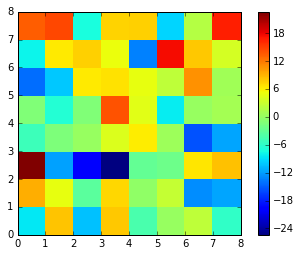

In [11]:
n = 8
SIGMA = 1.0
N = n*n
w = np.random.normal (scale=SIGMA, size=N)
K = 0.1
ALPHA = 1.0
A_2d = gen_grid_graph (n)

x_0 = np.zeros (N)
print ("x_0:", x_0)
print ("F (x_0):", F (x_0, A_2d, w, K, ALPHA))

def F_ode (x, t, A, w, k, alpha):
    return F (x, A, w, k, alpha)

t_all = [0.0, 10.0]
x_t = odeint (F_ode, x_0, t_all, args=(A_2d, w, K, ALPHA))
print ("x_t:", x_t)
plt.pcolor (np.reshape (x_t[1], (n, n)))
plt.colorbar ()
plt.axes().set_aspect('equal')

In [12]:
n = 8
SIGMA = 1.0
N = n*n
w = np.random.normal (scale=SIGMA, size=N)
print ("n:", n)
print ("w:", w)

def sim (x_0, k, alpha, t):
    t_all = np.array ([0.0, t])
    x_t = odeint (F_ode, x_0, t_all, args=(A_2d, w, k, alpha))
    return x_t[1]

def isim (k=0.0, alpha=1.0, t=0.0):
    x_t = sim (x_0, k, alpha, t)
    plt.pcolor (np.reshape (x_t, (n, n)))
    plt.colorbar ()
    plt.axes().set_aspect('equal')
    print ("(k=%g, alpha=%g, t=%g) done!" % (k, alpha, t))

n: 8
w: [ 1.17759072 -0.23641957 -0.66717717  0.64997063  0.60543253 -0.6299541  -0.44736264  0.06787954
 -0.57012201 -1.43379409 -0.05153295 -2.32879532 -0.79072198  0.65401353  0.14975139 -0.65467971
  1.29384009 -0.78786303 -0.25911497 -1.24517665 -0.20050587 -0.76176191  0.70882762  1.06209185
  0.84159229 -0.21382899  1.5593501  -1.72292313  2.04575342  1.0621427   1.0658803  -1.53916172
 -0.68398623  0.03014162 -0.21689439 -1.06486441  1.17603813  1.00286685 -0.42853118 -1.86671676
 -2.08554373 -0.35491544  0.11588632  2.10619534 -1.82394692 -0.43532247  0.29416865 -0.04924534
  1.15937824  1.65593266 -1.43670197  1.312741    0.69082767  1.06444942 -0.84913143  1.01994297
  0.26076538  0.07813747 -1.00554084  0.7746188  -1.1147829   0.12680142  0.90483712  1.45091335]


(k=0, alpha=1, t=10) done!


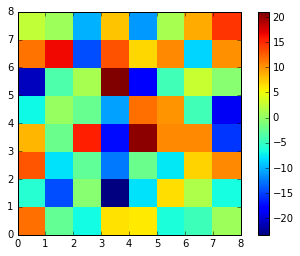

In [13]:
isim (0.0, alpha=1.0, t=10.0)

(k=10, alpha=1, t=6) done!


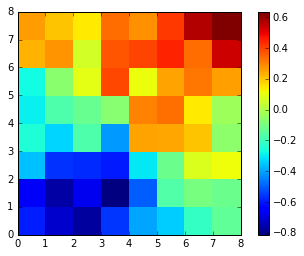

In [14]:
from ipywidgets import interact
interact (isim, k=(0.0, 10.0, 1.0), alpha=(0.1, 1.0, 0.1), t=(0.0, 10.0, 1.0)) ;

**Exercise.** What do you observe as `k` increases from `0` to `10`?

> Your answer here: as k increases, the grid becomes more synchronized
